In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf


/home/jiarui/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Preprocess Data
In the <b>HW3_template</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas (You have used it in HW1) to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [3]:
tesla_stocks = pd.read_csv('TSLA.csv')
tesla_data = np.asarray(tesla_stocks['Open']).reshape(-1,1)
print("# of Telsa records:",len(tesla_data))
tesla_stocks.head()

# of Telsa records: 2227


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [4]:
google_stocks = pd.read_csv('GOOGL.csv')
google_data = np.asarray(google_stocks['Open']).reshape(-1,1)
print("# of Google records:",len(google_data))
google_stocks.head()

# of Google records: 3702


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000
1,2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300
2,2004-08-23,55.430431,56.796795,54.579578,54.754753,54.754753,18256100
3,2004-08-24,55.675674,55.855854,51.836838,52.487488,52.487488,15247300
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188600


In [5]:
DJ_stocks = pd.read_csv('DJI.csv')
DJ_data = np.asarray(DJ_stocks['Open']).reshape(-1,1)
print("# of DJ records:",len(DJ_data))
DJ_stocks.head()

# of DJ records: 8636


,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000
1,1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000
2,1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000
3,1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000
4,1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000


## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [6]:
scaler = MinMaxScaler()
scaler.fit(tesla_data)
norm_telsa = scaler.transform(tesla_data)

scaler.fit(google_data)
norm_google = scaler.transform(google_data)

scaler.fit(DJ_data)
norm_DJ = scaler.transform(DJ_data)

# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [7]:
BATCH_SIZE = 32
SEQ_LEN = 8
RATIO = [0.7, 0.1, 0.2]

def split_seq(data, seq_len):
    data_x = []
    data_y = []
    i = 0
    while (i+seq_len) <= len(data)-1:
        data_x.append(data[i:i+seq_len])
        data_y.append(data[i+seq_len])        
        i += 1
    assert len(data_x) ==  len(data_y)
    return data_x,data_y
'''
def split_batch(data, batch_size):
    split_data = []
    i = 0
    while batch_size*(i+1)<len(data):
        split_data.append(data[batch_size*i:batch_size*(i+1)])
        i+=1
    split_data.append(data[batch_size*i:])
    return split_data
'''
def split_data(data, ratio, seq_len):
    
    split_data = {}
    
    data_x,data_y = split_seq(data, seq_len)
    
    train_x = data_x[:int(len(data_x)*ratio[0])]
    train_y = data_y[:int(len(data_y)*ratio[0])]
    
    val_x = data_x[int(len(data_x)*ratio[1]):int(len(data_x)*ratio[2])]
    val_y = data_y[int(len(data_y)*ratio[1]):int(len(data_y)*ratio[2])]
    
    test_x = data_x[int(len(data_x)*ratio[2]):]
    test_y = data_y[int(len(data_y)*ratio[2]):]
    
    split_data['train'] = [train_x,train_y]
    split_data['val'] = [val_x,val_y]
    split_data['test'] = [test_x,test_y]
    
    return split_data

telsa_data = split_data(norm_telsa,RATIO,SEQ_LEN)
google_data = split_data(norm_google,RATIO,SEQ_LEN)
DJ_data = split_data(norm_DJ,RATIO,SEQ_LEN)

print(np.asarray(telsa_data['train'][0]).shape,np.asarray(telsa_data['train'][1]).shape)
print(np.asarray(telsa_data['val'][0]).shape,np.asarray(telsa_data['val'][1]).shape)
print(np.asarray(telsa_data['test'][0]).shape,np.asarray(telsa_data['test'][1]).shape)


(1553, 8, 1) (1553, 1)
(222, 8, 1) (222, 1)
(1776, 8, 1) (1776, 1)


# TesnorFlow Model

In [8]:
#Hyperparameters of LSTM model
hidden_layer = 128
learning_rate = 0.001 
epochs = 100
#Place holders
X = tf.placeholder(tf.float32, [BATCH_SIZE, SEQ_LEN, 1])
Y = tf.placeholder(tf.float32, [BATCH_SIZE, 1])

#Define LSTM
#input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#forget gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))
#memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

## Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))

def LSTM_cell(input, output, state):
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    state = state * forget_gate + input_gate * memory_cell 
    output = output_gate * tf.tanh(state)
    return state, output

outputs = []
for i in range(BATCH_SIZE):
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    for j in range(SEQ_LEN):
        batch_state, batch_output = LSTM_cell(tf.reshape(X[i][j], (-1, 1)), batch_state, batch_output)
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
losses = []
for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(Y[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, 4)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

## Training

In [9]:
X_train = np.asarray(telsa_data['train'][0])
y_train = np.asarray(telsa_data['train'][1])
X_val = np.asarray(telsa_data['val'][0])
y_val = np.asarray(telsa_data['val'][1])
X_test = np.asarray(telsa_data['test'][0])
y_test = np.asarray(telsa_data['test'][1])

#print(X_train.shape,y_train.shape)
#print(X_val.shape,y_val.shape)
#print(X_test.shape,y_test.shape)

session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    j = 0
    epoch_loss = []
    val_epoch_loss = []
    while(j + BATCH_SIZE) <= len(X_train):
        X_batch = X_train[j:j+BATCH_SIZE]
        y_batch = y_train[j:j+BATCH_SIZE]      
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={X:X_batch, Y:y_batch})     
        epoch_loss.append(c)
        traind_scores.append(o)
        j+=BATCH_SIZE
    j=0    
    while(j + BATCH_SIZE) <= len(X_val):
        X_batch = X_val[j:j+BATCH_SIZE]
        y_batch = y_val[j:j+BATCH_SIZE]      
        c = session.run(loss, feed_dict={X:X_batch, Y:y_batch})     
        val_epoch_loss.append(c)
        j += BATCH_SIZE
        
    if (i % 10) == 0:
        print('Epoch {}/{}'.format(i, epochs), 'Training loss: {}'.format(np.mean(epoch_loss)), 'Val loss: {}'.format(np.mean(val_epoch_loss)))

Epoch 0/100 Training loss: 0.0172057393938303 Val loss: 0.10390505939722061
Epoch 10/100 Training loss: 0.003111303085461259 Val loss: 0.0009018117561936378
Epoch 20/100 Training loss: 0.004506843630224466 Val loss: 0.004343374632298946
Epoch 30/100 Training loss: 0.0025266993325203657 Val loss: 0.0010292691877111793
Epoch 40/100 Training loss: 0.002111820736899972 Val loss: 0.000818104250356555
Epoch 50/100 Training loss: 0.0016112109879031777 Val loss: 0.00036845981958322227
Epoch 60/100 Training loss: 0.001334099448285997 Val loss: 0.0002757921174634248
Epoch 70/100 Training loss: 0.0011118263937532902 Val loss: 0.00015397195238620043
Epoch 80/100 Training loss: 0.0009285879787057638 Val loss: 0.000112569221528247
Epoch 90/100 Training loss: 0.0008194632828235626 Val loss: 7.877412281231955e-05


# Testing

In [ ]:
preds = []
i = 0
while i+BATCH_SIZE <= len(X_test):
    o = session.run([outputs], feed_dict={X:X_test[i:i+BATCH_SIZE]})
    i += BATCH_SIZE
    preds.append(o)

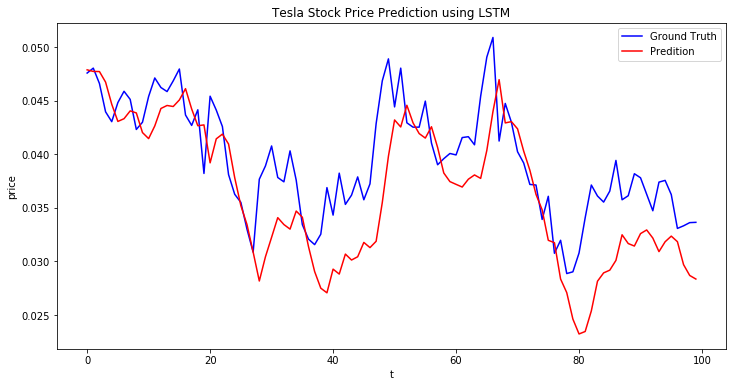

In [24]:
preds = np.squeeze(np.asarray(preds)).flatten()

plt.figure(figsize=(12,6))
plt.plot(range(100),y_test[0:100],color='blue')
plt.plot(range(100),preds[0:100],color='red')
plt.legend(['Ground Truth','Predition'])
plt.xlabel('t')
plt.ylabel('price')
plt.title('Tesla Stock Price Prediction using LSTM')
plt.show()

## Traning and Testing for Google 

In [10]:
X_train = np.asarray(google_data['train'][0])
y_train = np.asarray(google_data['train'][1])
X_val = np.asarray(google_data['val'][0])
y_val = np.asarray(google_data['val'][1])
X_test = np.asarray(google_data['test'][0])
y_test = np.asarray(google_data['test'][1])

#print(X_train.shape,y_train.shape)
#print(X_val.shape,y_val.shape)
#print(X_test.shape,y_test.shape)

session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    j = 0
    epoch_loss = []
    val_epoch_loss = []
    while(j + BATCH_SIZE) <= len(X_train):
        X_batch = X_train[j:j+BATCH_SIZE]
        y_batch = y_train[j:j+BATCH_SIZE]      
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={X:X_batch, Y:y_batch})     
        epoch_loss.append(c)
        traind_scores.append(o)
        j+=BATCH_SIZE
    j=0    
    while(j + BATCH_SIZE) <= len(X_val):
        X_batch = X_val[j:j+BATCH_SIZE]
        y_batch = y_val[j:j+BATCH_SIZE]      
        c = session.run(loss, feed_dict={X:X_batch, Y:y_batch})     
        val_epoch_loss.append(c)
        j += BATCH_SIZE
        
    if (i % 10) == 0:
        print('Epoch {}/{}'.format(i, epochs), 'Training loss: {}'.format(np.mean(epoch_loss)), 'Val loss: {}'.format(np.mean(val_epoch_loss)))

Epoch 0/100 Training loss: 0.0018595848232507706 Val loss: 0.026017094030976295
Epoch 10/100 Training loss: 2.8784595997422002e-05 Val loss: 1.398779477312928e-05
Epoch 20/100 Training loss: 2.9512888431781903e-05 Val loss: 9.453052916796878e-05
Epoch 30/100 Training loss: 0.00019203397096134722 Val loss: 0.003956738393753767
Epoch 40/100 Training loss: 0.00012274234904907644 Val loss: 0.00042764117824845016
Epoch 50/100 Training loss: 3.8550981116713956e-05 Val loss: 0.00013556343037635088
Epoch 60/100 Training loss: 4.511673250817694e-05 Val loss: 0.00014914810890331864
Epoch 70/100 Training loss: 6.761906115571037e-05 Val loss: 0.00034417296410538256
Epoch 80/100 Training loss: 0.00020803599909413606 Val loss: 0.0031302946154028177
Epoch 90/100 Training loss: 0.00016995950136333704 Val loss: 0.000874947989359498


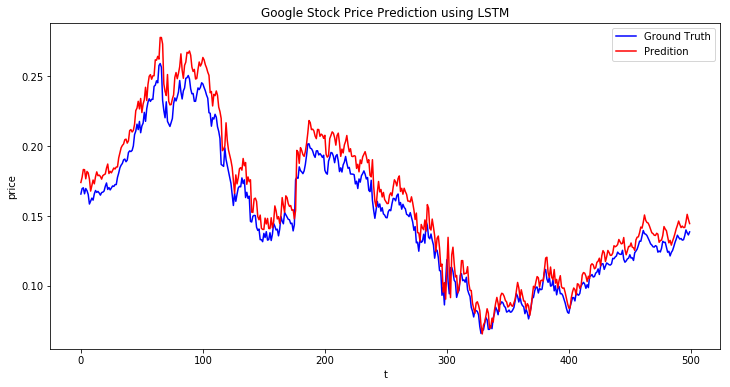

In [11]:
preds = []
i = 0
while i+BATCH_SIZE <= len(X_test):
    o = session.run([outputs], feed_dict={X:X_test[i:i+BATCH_SIZE]})
    i += BATCH_SIZE
    preds.append(o)
preds = np.squeeze(np.asarray(preds)).flatten()

plt.figure(figsize=(12,6))
plt.plot(range(500),y_test[0:500],color='blue')
plt.plot(range(500),preds[0:500],color='red')
plt.legend(['Ground Truth','Predition'])
plt.xlabel('t')
plt.ylabel('price')
plt.title('Google Stock Price Prediction using LSTM')
plt.show()

## Traning and Testing for DJI

In [9]:
X_train = np.asarray(DJ_data['train'][0])
y_train = np.asarray(DJ_data['train'][1])
X_val = np.asarray(DJ_data['val'][0])
y_val = np.asarray(DJ_data['val'][1])
X_test = np.asarray(DJ_data['test'][0])
y_test = np.asarray(DJ_data['test'][1])

#print(X_train.shape,y_train.shape)
#print(X_val.shape,y_val.shape)
#print(X_test.shape,y_test.shape)

session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    j = 0
    epoch_loss = []
    val_epoch_loss = []
    while(j + BATCH_SIZE) <= len(X_train):
        X_batch = X_train[j:j+BATCH_SIZE]
        y_batch = y_train[j:j+BATCH_SIZE]      
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={X:X_batch, Y:y_batch})     
        epoch_loss.append(c)
        traind_scores.append(o)
        j+=BATCH_SIZE
    j=0    
    while(j + BATCH_SIZE) <= len(X_val):
        X_batch = X_val[j:j+BATCH_SIZE]
        y_batch = y_val[j:j+BATCH_SIZE]      
        c = session.run(loss, feed_dict={X:X_batch, Y:y_batch})     
        val_epoch_loss.append(c)
        j += BATCH_SIZE
        
    if (i % 10) == 0:
        print('Epoch {}/{}'.format(i, epochs), 'Training loss: {}'.format(np.mean(epoch_loss)), 'Val loss: {}'.format(np.mean(val_epoch_loss)))

Epoch 0/100 Training loss: 0.0005430126329883933 Val loss: 0.039079152047634125
Epoch 10/100 Training loss: 0.0002742484211921692 Val loss: 0.001812840928323567
Epoch 20/100 Training loss: 0.00016441145271528512 Val loss: 0.0011049784952774644
Epoch 30/100 Training loss: 0.00019189536396879703 Val loss: 0.0016626800643280149
Epoch 40/100 Training loss: 0.00012553893611766398 Val loss: 0.000332910887664184
Epoch 50/100 Training loss: 0.00014336549793370068 Val loss: 0.00025202546385116875
Epoch 60/100 Training loss: 0.0001080204892787151 Val loss: 0.0001091215162887238
Epoch 70/100 Training loss: 9.40947065828368e-05 Val loss: 0.0010958791244775057
Epoch 80/100 Training loss: 8.366873225895688e-05 Val loss: 0.0002970673958770931
Epoch 90/100 Training loss: 7.130039011826739e-05 Val loss: 3.7860121665289626e-05


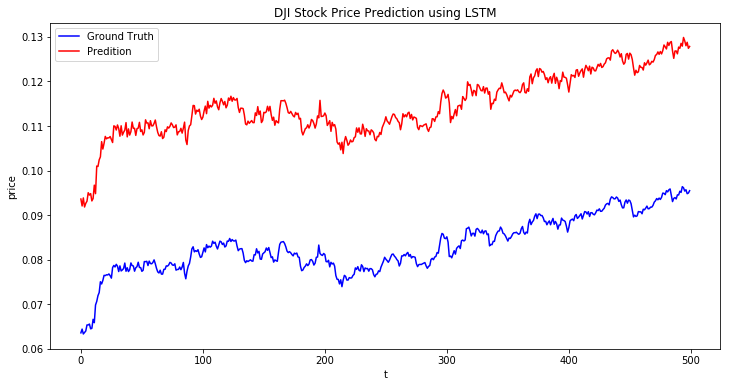

In [10]:
preds = []
i = 0
while i+BATCH_SIZE <= len(X_test):
    o = session.run([outputs], feed_dict={X:X_test[i:i+BATCH_SIZE]})
    i += BATCH_SIZE
    preds.append(o)
preds = np.squeeze(np.asarray(preds)).flatten()

plt.figure(figsize=(12,6))
plt.plot(range(500),y_test[0:500],color='blue')
plt.plot(range(500),preds[0:500],color='red')
plt.legend(['Ground Truth','Predition'])
plt.xlabel('t')
plt.ylabel('price')
plt.title('DJI Stock Price Prediction using LSTM')
plt.show()